Source: 

https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-for-text-classification-tasks

#Kaggle

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
# upload JSON file with account info from kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aleksmitk","key":"bba949f84eb8bac61aff3e5e51ea87e0"}'}

In [33]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
# Choose the kaggle.json file that you downloaded
! cp kaggle.json ~/.kaggle/
# Download dataset from kaggle
! kaggle datasets download neisse/scrapped-lyrics-from-6-genres
! unzip scrapped-lyrics-from-6-genres
! rm -r scrapped-lyrics-from-6-genres.zip

100% 129M/129M [00:04<00:00, 37.5MB/s]
100% 129M/129M [00:04<00:00, 32.3MB/s]
Archive:  scrapped-lyrics-from-6-genres.zip
  inflating: artists-data.csv        
  inflating: lyrics-data.csv         


# Preprocessing

In [54]:
import pandas as pd
lyrics_data = pd.read_csv("/content/lyrics-data.csv")
artists_data = pd.read_csv("/content/artists-data.csv")

lyrics_data = lyrics_data.rename({"ALink":"Link"}, axis="columns")
data = lyrics_data.merge(artists_data, on='Link', how='left')
data = data.drop(["Link", "SName", "SLink", "Songs", "Popularity"], axis=1)
data = data.loc[data["language"] == "en"]
data[['Genre1', 'Genre2', 'Genre3', 'Genre4']] = data['Genres'].str.split(';', -1, expand=True)
data = data[data['Genre1'].notna()]
data = data.drop("Genres", axis=1)
data = data.reset_index().drop("index", axis=1)

other_genres = []
for genre in data['Genre1'].unique():
  freq = len(data[data["Genre1"] == genre])
  if freq <1200:
    other_genres.append(genre)

for index, row in data.iterrows():
  if (row["Genre1"] == "Pop/Rock") & (row["Genre2"] == " Pop"):
    data.loc[index, "Genre1"] = "Pop"
  
  if (row["Genre1"] == "Rap"):
    data.loc[index, "Genre1"] = "Hip Hop"

  if (row["Genre1"] == "Rock Alternativo") & (row["Genre2"] == " Indie"):
    data.loc[index, "Genre1"] = "Indie"

  if (row["Genre1"] == "Black Music") & (row["Genre2"] == " R&B"):
    data.loc[index, "Genre1"] = "R&B"

  if (row["Genre1"] == "Black Music") & (row["Genre2"] == " Soul Music"):
    data.loc[index, "Genre1"] = "R&B"

  if (row["Genre1"] == "Soul Music") & (row["Genre2"] == " R&B"):
    data.loc[index, "Genre1"] = "R&B"

  if (row["Genre1"] == "Soul Music") & (row["Genre2"] == " Pop"):
    data.loc[index, "Genre1"] = "R&B"

  if (row["Genre1"] == "Dance") & (row["Genre2"] == " Pop"):
    data.loc[index, "Genre1"] = "Pop"

  if (row["Genre1"] == "Folk") & (row["Genre2"] == " Indie"):
    data.loc[index, "Genre1"] = "Indie"

  if (row["Genre1"] == "Folk") & (row["Genre3"] == " Indie"):
    data.loc[index, "Genre1"] = "Indie"

  if (row["Genre1"] == "Romântico") & (row["Genre3"] == " R&B"):
    data.loc[index, "Genre1"] = "R&B"
  
  if (row["Genre1"] == "Pop") & (row["Genre2"] == " R&B"):
    data.loc[index, "Genre1"] = "R&B"

  if (row["Genre1"] == "Rock") & (row["Genre2"] == " Country"):
    data.loc[index, "Genre1"] = "Country" 
  
  if (row["Genre1"] == "Trilha Sonora") & (row["Genre2"] == " Country"):
    data.loc[index, "Genre1"] = "Country" 

  if (row["Genre1"] == "Folk") & (row["Genre2"] == " Country"):
    data.loc[index, "Genre1"] = "Country" 

  if row["Genre1"] in other_genres:
    data.loc[index, "Genre1"] = "Other" 
  
  ###New changes:###
  if (row["Genre1"] == "Rock") & (row["Genre2"] == " Pop"):
    data.loc[index, "Genre1"] = "Pop"  

  if (row["Artist"] == "Wilco"):
    data.loc[index, "Genre1"] = "Country" 

  if (row["Genre1"] == "Rock") & (row["Genre2"] == " Indie"):
    data.loc[index, "Genre1"] = "Indie"  

  if (row["Artist"] == "Steve Earle"):
    data.loc[index, "Genre1"] = "Country" 

  if (row["Genre1"] == "Rock") & (row["Genre2"] == " Heavy Metal"):
    data.loc[index, "Genre1"] = "Heavy Metal"  

  if (row["Genre1"] == "Pop") & (row["Genre3"] == " R&B"):
    data.loc[index, "Genre1"] = "Pop"  
  
  if (row["Artist"] in ['Ciara', 'Jeremih', 'Kehlani','Ashanti', 'Jhené Aiko', 'Ray J', 'Omarion', 'Mindless Behavior']):
        data.loc[index, "Genre1"] = "R&B"  

genre_list = ["Rock","Hip Hop","Pop","Indie","Heavy Metal","R&B", "Country"]
data = data[data["Genre1"].isin(genre_list)]

In [55]:
freq_list = []
for genre in data['Genre1'].unique():
  freq = len(data[data["Genre1"] == genre])
  freq_list.append((freq, genre))

print(sorted(freq_list, key = lambda x: x[0], reverse=True))

[(22352, 'Rock'), (17240, 'Hip Hop'), (17002, 'Pop'), (16137, 'Indie'), (14353, 'Heavy Metal'), (12425, 'R&B'), (8657, 'Country')]


In [56]:
decode_labels = {}
i = 0
for label in data["Genre1"].unique():
  decode_labels[i] = label
  i += 1
encode_labels = {v: k for k, v in decode_labels.items()}

import re 

def clean_lyrics(lyrics):
    lyrics = re.sub(r"[^A-Za-z0-9']+", " ", lyrics, flags=re.MULTILINE)
    lyrics = re.sub(r"(?<=[a-zA-Z0-9]) (?=['])|(?<=[']) (?=[a-zA-Z0-9])", "", lyrics, flags=re.MULTILINE)
    lyrics = re.sub('\s+',' ',lyrics)
    return lyrics.lower().lstrip()

for index, row in data.iterrows(): #encode labels in dataset 
  label = encode_labels[row["Genre1"]]
  data.loc[index,'Label'] = label

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.05)

In [57]:
from torch.utils.data import Dataset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)


class AudioDataset(Dataset):
  def __init__(self, dataset: pd.DataFrame):
      self.lyrics = dataset['Lyric'].tolist()
      self.labels = dataset["Label"].tolist()

  def __len__(self):
      return len(self.lyrics)

  def __getitem__(self, index: int):
      feat = clean_lyrics(self.lyrics[index])
      label = int(self.labels[index])
      
      return (label, feat)
  
  def collate_fn(batch):
      label_list = [torch.tensor(label_pipeline(b[0])) for b in batch]
      feat_list = [torch.tensor(text_pipeline(b[1])) for b in batch]

      feats = torch.nn.utils.rnn.pad_sequence(feat_list, batch_first = True)
      labels = torch.tensor(label_list, dtype=torch.int64)

      """
      print(f"Features shape: {feats.shape}")
      print(f"Labels shape: {labels.shape}")
      print(f"Length of tensor: {len(feats[1])}")
      translation = []
      [translation.append(" " + str(vocab.lookup_token(word.item()))) for word in feats[1]]
      translation = ''.join(translation)
      print(f"Translated tensor: {translation}")
      print(f"Corresponding label: {decode_labels[labels[1].item()]}")
      """

      return feats.to(device), labels.to(device)

    
train_iter = AudioDataset(dataset=train_data)
test_iter = AudioDataset(dataset=test_data)

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<pad>","<unk>"], min_freq = 500)
vocab.set_default_index(vocab["<unk>"])

dataloader = DataLoader(train_iter, batch_size=8, shuffle=True, collate_fn=AudioDataset.collate_fn)
test_loader = DataLoader(test_iter, batch_size=8, shuffle=False, collate_fn=AudioDataset.collate_fn)

In [58]:
import numpy as np
torch.set_printoptions(profile="full")#"default"
print("Model overview:")
print(" ")

for X, Y in dataloader:
  print(X.shape)
  print(Y.shape)
  break

Model overview:
 
torch.Size([8, 774])
torch.Size([8])


# Model und Training Tests

In [59]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 75
n_layers=1
num_class = len(set([label for (label, text) in train_iter]))

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_class)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(embeddings, (hidden.to(device), carry.to(device)))
        output = self.dropout(output)
        return self.linear(output[:,-1])

In [60]:
lstm_classifier = LSTMClassifier().to(device)

lstm_classifier

LSTMClassifier(
  (embedding_layer): Embedding(3129, 50)
  (lstm): LSTM(50, 75, batch_first=True)
  (linear): Linear(in_features=75, out_features=7, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [61]:
for layer in lstm_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(3129, 50)
Parameters : 
torch.Size([3129, 50])

Layer : LSTM(50, 75, batch_first=True)
Parameters : 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer : Linear(in_features=75, out_features=7, bias=True)
Parameters : 
torch.Size([7, 75])
torch.Size([7])

Layer : Dropout(p=0.3, inplace=False)
Parameters : 



In [70]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/best_model.pth')

save_best_model = SaveBestModel()

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=8, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

early_stopping = EarlyStopping()

In [71]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader, epoch):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        early_stopping(torch.tensor(losses).mean())

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())))
        save_best_model(torch.tensor(losses).mean(), epoch, model, optimizer, loss_fn) # save best checkpoint added
        print('-'*50)
        scheduler.step(torch.tensor(losses).mean()) # scheduler added


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X) ## Make Predictions

            loss = loss_fn(Y_preds, Y) ## Calculate Loss
            losses.append(loss.item())

            optimizer.zero_grad() ## Clear previously calculated gradients
            loss.backward() ## Calculates Gradients
            optimizer.step() ## Update network weights.

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader, i)
        if early_stopping.early_stop:
          break

In [72]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

epochs = 100
learning_rate = 0.001#1e-3

loss_fn = nn.CrossEntropyLoss()
lstm_classifier = LSTMClassifier().to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                optimizer,
                mode='min',
                patience=2,
                factor=0.5,
                min_lr=1e-6,
                verbose=True
            ) # scheduler added

TrainModel(lstm_classifier, loss_fn, optimizer, dataloader, test_loader, epochs)

100%|██████████| 12845/12845 [01:59<00:00, 107.41it/s]


Train Loss : 1.731
Valid Loss : 1.510
Valid Acc  : 0.400

Best validation loss: 1.5102300643920898

Saving best model for epoch: 1

--------------------------------------------------


100%|██████████| 12845/12845 [02:00<00:00, 106.29it/s]


Train Loss : 1.414
Valid Loss : 1.360
Valid Acc  : 0.449

Best validation loss: 1.3599365949630737

Saving best model for epoch: 2

--------------------------------------------------


100%|██████████| 12845/12845 [01:58<00:00, 108.54it/s]


Train Loss : 1.303
Valid Loss : 1.293
Valid Acc  : 0.497

Best validation loss: 1.2928539514541626

Saving best model for epoch: 3

--------------------------------------------------


100%|██████████| 12845/12845 [01:58<00:00, 108.05it/s]


Train Loss : 1.246
Valid Loss : 1.267
Valid Acc  : 0.503

Best validation loss: 1.267111897468567

Saving best model for epoch: 4

--------------------------------------------------


100%|██████████| 12845/12845 [01:59<00:00, 107.83it/s]


Train Loss : 1.196
Valid Loss : 1.235
Valid Acc  : 0.516

Best validation loss: 1.23540461063385

Saving best model for epoch: 5

--------------------------------------------------


100%|██████████| 12845/12845 [02:00<00:00, 106.79it/s]


Train Loss : 1.161
Valid Loss : 1.228
Valid Acc  : 0.527

Best validation loss: 1.2276972532272339

Saving best model for epoch: 6

--------------------------------------------------


100%|██████████| 12845/12845 [01:58<00:00, 108.10it/s]


Train Loss : 1.142
INFO: Early stopping counter 1 of 8
Valid Loss : 1.249
Valid Acc  : 0.523
--------------------------------------------------


100%|██████████| 12845/12845 [01:58<00:00, 108.80it/s]


Train Loss : 1.119
Valid Loss : 1.225
Valid Acc  : 0.541

Best validation loss: 1.225380301475525

Saving best model for epoch: 8

--------------------------------------------------


100%|██████████| 12845/12845 [02:00<00:00, 107.03it/s]


Train Loss : 1.094
INFO: Early stopping counter 1 of 8
Valid Loss : 1.232
Valid Acc  : 0.535
--------------------------------------------------


100%|██████████| 12845/12845 [01:58<00:00, 107.98it/s]


Train Loss : 1.160
INFO: Early stopping counter 2 of 8
Valid Loss : 1.250
Valid Acc  : 0.534
--------------------------------------------------


100%|██████████| 12845/12845 [01:58<00:00, 108.23it/s]


Train Loss : 1.071
INFO: Early stopping counter 3 of 8
Valid Loss : 1.240
Valid Acc  : 0.529
--------------------------------------------------
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 12845/12845 [01:59<00:00, 107.33it/s]


Train Loss : 1.002
INFO: Early stopping counter 4 of 8
Valid Loss : 1.249
Valid Acc  : 0.540
--------------------------------------------------


100%|██████████| 12845/12845 [01:59<00:00, 107.79it/s]


Train Loss : 0.974
INFO: Early stopping counter 5 of 8
Valid Loss : 1.268
Valid Acc  : 0.531
--------------------------------------------------


100%|██████████| 12845/12845 [01:57<00:00, 109.02it/s]


Train Loss : 0.948
INFO: Early stopping counter 6 of 8
Valid Loss : 1.291
Valid Acc  : 0.534
--------------------------------------------------
Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 12845/12845 [02:00<00:00, 106.74it/s]


Train Loss : 0.896
INFO: Early stopping counter 7 of 8
Valid Loss : 1.324
Valid Acc  : 0.529
--------------------------------------------------


100%|██████████| 12845/12845 [01:58<00:00, 108.62it/s]


Train Loss : 0.874
INFO: Early stopping counter 8 of 8
INFO: Early stopping
Valid Loss : 1.341
Valid Acc  : 0.532
--------------------------------------------------


In [33]:
#torch.save(lstm_classifier.state_dict(), "lstm_model.pth")
torch.save({'epoch': epochs,
            'model_state_dict': lstm_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,}, 'final_model.pth')
torch.save(vocab, 'vocab.pth')

In [73]:
torch.cuda.empty_cache()
gc.collect()

6409

In [74]:
def MakePredictions(model, loader):
      Y_shuffled, Y_preds = [], []
      with torch.no_grad():
        for X, Y in loader:
            preds = model(X)
            Y_preds.append(preds)
            Y_shuffled.append(Y)
        gc.collect()
        Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

      return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader)


In [75]:
target_classes = []
for index, genre in decode_labels.items():
  target_classes.append(genre)

print(target_classes)

['Pop', 'R&B', 'Hip Hop', 'Rock', 'Indie', 'Country', 'Heavy Metal']


In [76]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.5322610464041413

Classification Report : 
              precision    recall  f1-score   support

         Pop       0.44      0.47      0.45       855
         R&B       0.46      0.37      0.41       600
     Hip Hop       0.77      0.81      0.79       840
        Rock       0.42      0.42      0.42      1127
       Indie       0.43      0.50      0.46       808
     Country       0.59      0.52      0.55       445
 Heavy Metal       0.69      0.63      0.66       734

    accuracy                           0.53      5409
   macro avg       0.54      0.53      0.54      5409
weighted avg       0.54      0.53      0.53      5409


Confusion Matrix : 
[[400 102  48 137 127  27  14]
 [147 224  95  82  30  18   4]
 [ 45  61 679  20  24   6   5]
 [148  53  28 478 233  71 116]
 [ 97  15  19 189 401  28  59]
 [ 47  22   6  89  42 232   7]
 [ 23   5   8 142  81  10 465]]


In [68]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


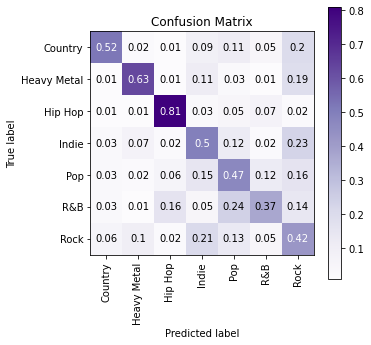

In [77]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [ ]:
plt.savefig("confusion_matrix")

# Predictions

In [5]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 75
n_layers=1
num_class = 7

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(input_size=embed_len, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_class)
        self.dropout = nn.Dropout(0.3)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.randn(n_layers, len(X_batch), hidden_dim), torch.randn(n_layers, len(X_batch), hidden_dim)
        output, (hidden, carry) = self.lstm(embeddings, (hidden.to(device), carry.to(device)))
        output = self.dropout(output)
        return self.linear(output[:,-1])

In [30]:
import torch
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab = torch.load('vocab.pth')
lstm_classifier = LSTMClassifier().to(device)
optimizer = Adam(lstm_classifier.parameters(), lr=0.001, weight_decay=1e-5)

checkpoint = torch.load("/content/final_model.pth")
lstm_classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
#model.load_state_dict(torch.load("/content/best_model.pth", map_location=torch.device('cpu')))
lstm_classifier.eval()

from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

text_pipeline = lambda x: vocab(tokenizer(x))

import regex as re
def clean_lyrics(lyrics):
    lyrics = re.sub(r"[^A-Za-z0-9']+", " ", lyrics, flags=re.MULTILINE)
    lyrics = re.sub(r"(?<=[a-zA-Z0-9]) (?=['])|(?<=[']) (?=[a-zA-Z0-9])", "", lyrics, flags=re.MULTILINE)
    lyrics = re.sub('\s+',' ',lyrics)
    return lyrics.lower().lstrip()

decode_labels = {0:"Pop",1:"R&B",2:"Hip Hop",3:"Rock",4:"Indie",5:"Country",6:"Heavy Metal"}

In [79]:
lyrics = """I have this thing where I get older but just never wiser
Midnights become my afternoons
When my depression works the graveyard shift
All of the people I've ghosted stand there in the room
I should not be left to my own devices
They come with prices and vices
I end up in crisis (tale as old as time)
I wake up screaming from dreaming
One day I'll watch as you're leaving
'Cause you got tired of my scheming
(For the last time)
It's me, hi, I'm the problem, it's me
At tea time, everybody agrees
I'll stare directly at the sun but never in the mirror
It must be exhausting always rooting for the anti-hero
Sometimes I feel like everybody is a sexy baby
And I'm a monster on the hill
Too big to hang out, slowly lurching toward your favorite city
Pierced through the heart, but never killed
Did you hear my covert narcissism I disguise as altruism
Like some kind of congressman? (Tale as old as time)
I wake up screaming from dreaming
One day I'll watch as you're leaving
And life will lose all its meaning
(For the last time)
It's me, hi, I'm the problem, it's me (I'm the problem, it's me)
At tea time, everybody agrees
I'll stare directly at the sun but never in the mirror
It must be exhausting always rooting for the anti-hero
I have this dream my daughter in-law kills me for the money
She thinks I left them in the will
The family gathers 'round and reads it and then someone screams out
"She's laughing up at us from hell"
It's me, hi, I'm the problem, it's me
It's me, hi, I'm the problem, it's me
It's me, hi, everybody agrees, everybody agrees
It's me, hi (hi), I'm the problem, it's me (I'm the problem, it's me)
At tea (tea) time (time), everybody agrees (everybody agrees)
I'll stare directly at the sun but never in the mirror
It must be exhausting always rooting for the anti-hero
"""
pred = lstm_classifier(torch.tensor(text_pipeline(clean_lyrics(lyrics))).unsqueeze(0).to(device))
decode_labels[F.softmax(pred, dim=-1).argmax(dim=-1).item()]

'Pop'

# Sonstiges

In [ ]:
data.head()

,Lyric,language,Artist,Genre1,Genre2,Genre3,Genre4,Label
0,I feel so unsure\nAs I take your hand and lead...,en,Ivete Sangalo,Pop,Axé,Romântico,None,0.0
1,"Don't let them fool, ya\nOr even try to school...",en,Ivete Sangalo,Pop,Axé,Romântico,None,0.0
2,"Baby, let's cruise, away from here\nDon't be c...",en,Ivete Sangalo,Pop,Axé,Romântico,None,0.0
3,"Know it sounds funny\nBut, I just can't stand ...",en,Ivete Sangalo,Pop,Axé,Romântico,None,0.0
4,You've got that look again\nThe one I hoped I ...,en,Ivete Sangalo,Pop,Axé,Romântico,None,0.0


In [70]:
test = data[data["Artist"]=="Taylor Swift"]
lyrics = test.iloc[1,0]
pred = model(torch.tensor(text_pipeline(clean_lyrics(lyrics))).unsqueeze(0).to(device))
decode_labels[F.softmax(pred, dim=-1).argmax(dim=-1).item()]

'Indie'

In [74]:
prediction_df = pd.DataFrame({"Lyric":[lyrics], "Label":[0]})
print(prediction_df)

                                               Lyric  Label
0  I have this thing where I get older but just n...      0


In [75]:
from torch.utils.data import Dataset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)


class AudioDataset(Dataset):
  def __init__(self, dataset: pd.DataFrame):
      self.lyrics = dataset['Lyric'].tolist()
      self.labels = dataset["Label"].tolist()

  def __len__(self):
      return len(self.lyrics)

  def __getitem__(self, index: int):
      feat = clean_lyrics(self.lyrics[index])
      label = int(self.labels[index])
      
      return (label, feat)
  
  def collate_fn(batch):
      label_list = [torch.tensor(label_pipeline(b[0])) for b in batch]
      feat_list = [torch.tensor(text_pipeline(b[1])) for b in batch]

      feats = torch.nn.utils.rnn.pad_sequence(feat_list, batch_first = True)
      labels = torch.tensor(label_list, dtype=torch.int64)

      """
      print(f"Features shape: {feats.shape}")
      print(f"Labels shape: {labels.shape}")
      print(f"Length of tensor: {len(feats[1])}")
      translation = []
      [translation.append(" " + str(vocab.lookup_token(word.item()))) for word in feats[1]]
      translation = ''.join(translation)
      print(f"Translated tensor: {translation}")
      print(f"Corresponding label: {decode_labels[labels[1].item()]}")
      """

      return feats.to(device), labels.to(device)

    
pred_iter = AudioDataset(dataset=prediction_df)

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

#vocab = build_vocab_from_iterator(yield_tokens(pred_iter), specials=["<pad>","<unk>"], min_freq = 500)
#vocab.set_default_index(vocab["<unk>"])

dataloader = DataLoader(pred_iter, batch_size=1, shuffle=False, collate_fn=AudioDataset.collate_fn)


Y_preds = []
with torch.no_grad():
  for X, Y in dataloader:
            preds = model(X)
            Y_preds.append(preds)
  gc.collect()


decode_labels[F.softmax(Y_preds[0], dim=-1).argmax(dim=-1).cpu().detach().numpy().item()]

'Heavy Metal'